<a href="https://colab.research.google.com/github/NiravSingh/Comparison_NIDS-/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
train=pd.read_csv("/content/kddcup_data_10_percent_corrected.csv")

In [60]:
column_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target']

# Assign column names to the DataFrame
train.columns = column_names

In [61]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [62]:
# Specify the file path where you want to save the CSV file
#file_path = f"/content/drive/MyDrive/My datasets/kddcup_data_updated.csv"
file_path = f"/content/dataset/kddcup_data_updated.csv"

# Save the DataFrame to a CSV file
train.to_csv(file_path, index=False)

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  num_compromised              494020 non-null  int64  
 13 

Creating a dictionary of attack_types

In [64]:
attacks_types = {
    'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
}

In [65]:
# Adding Attack Type column
# train['Attack Type'] = train.target.apply(lambda r:attacks_types[r[:-1]])
train['Attack Type'] = train.target.apply(lambda r: attacks_types[r[:-1]])
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [66]:
train.shape

(494020, 43)

In [67]:
train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [68]:
# total = train.shape[0]
# missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
# for col in missing_columns:
#     null_count = train[col].isnull().sum()
#     per = (null_count/total) * 100
#     print(f"{col}: {null_count} ({round(per, 3)}%)")

In [69]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 348435


In [70]:
train.shape

(494020, 43)

<Axes: xlabel='Attack Type', ylabel='count'>

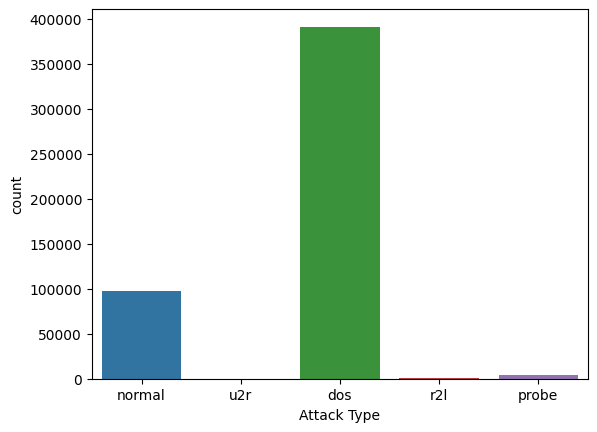

In [71]:
sns.countplot(x=train['Attack Type'])

In [72]:
print('Class distribution Training set:')
print(train['Attack Type'].value_counts())

Class distribution Training set:
dos       391458
normal     97277
probe       4107
r2l         1126
u2r           52
Name: Attack Type, dtype: int64


<ipython-input-73-43b8accca4d5>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  train = train.dropna('columns')
<ipython-input-73-43b8accca4d5>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


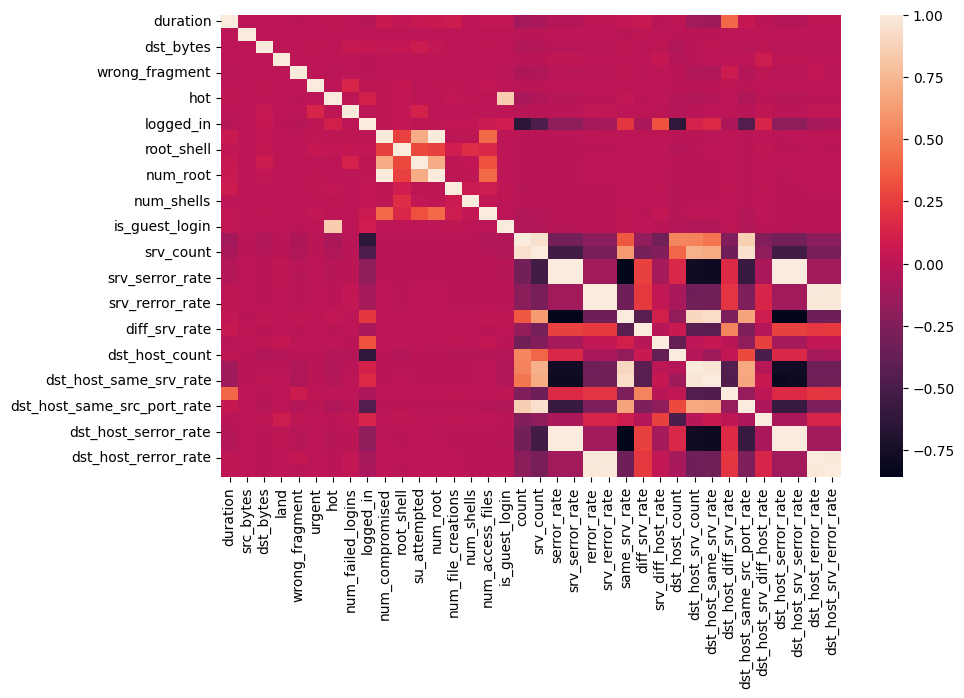

In [73]:
# drop columns with NaN
train = train.dropna('columns')

# keep columns where there are more than 1 unique values
train = train[[col for col in train if train[col].nunique() > 1]]

corr = train.corr()

plt.figure(figsize =(10, 6))

sns.heatmap(corr)

plt.show()

In [74]:
# This variable is highly correlated with num_compromised and should be ignored for analysis.
#(Correlation = 0.9938277978738366)
train.drop('num_root', axis = 1, inplace = True)

# This variable is highly correlated with serror_rate and should be ignored for analysis.
#(Correlation = 0.9983615072725952)
train.drop('srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9947309539817937)
train.drop('srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
#(Correlation = 0.9993041091850098)
train.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9869947924956001)
train.drop('dst_host_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9821663427308375)
train.drop('dst_host_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9851995540751249)
train.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9865705438845669)
train.drop('dst_host_same_srv_rate', axis = 1, inplace = True)

Feature Mapping: Apply feature mapping on features such as : protocol_type & flag.

In [75]:
 # protocol_type feature mapping
pmap = {'icmp':0, 'tcp':1, 'udp':2}
train['protocol_type'] = train['protocol_type'].map(pmap)


In [76]:
 # flag feature mapping
fmap = {'SF':0, 'S0':1, 'REJ':2, 'RSTR':3, 'RSTO':4, 'SH':5, 'S1':6, 'S2':7, 'RSTOS0':8, 'S3':9, 'OTH':10}
train['flag'] = train['flag'].map(fmap)


Remove irrelevant features such as ‘service’ before modelling

In [77]:
train.drop('service', axis = 1, inplace = True)

In [78]:
train.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,1,0,239,486,0,0,0,0,0,...,1.0,0.0,0.0,19,19,0.0,0.05,0.0,normal.,normal
1,0,1,0,235,1337,0,0,0,0,0,...,1.0,0.0,0.0,29,29,0.0,0.03,0.0,normal.,normal
2,0,1,0,219,1337,0,0,0,0,0,...,1.0,0.0,0.0,39,39,0.0,0.03,0.0,normal.,normal
3,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.0,49,49,0.0,0.02,0.0,normal.,normal
4,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.0,59,59,0.0,0.02,0.0,normal.,normal


In [79]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['Attack Type'] = label_encoder.fit_transform(train['Attack Type'])

In [80]:
train.head(500)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,target,Attack Type
0,0,1,0,239,486,0,0,0,0,0,...,1.0,0.0,0.00,19,19,0.0,0.05,0.00,normal.,1
1,0,1,0,235,1337,0,0,0,0,0,...,1.0,0.0,0.00,29,29,0.0,0.03,0.00,normal.,1
2,0,1,0,219,1337,0,0,0,0,0,...,1.0,0.0,0.00,39,39,0.0,0.03,0.00,normal.,1
3,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.00,49,49,0.0,0.02,0.00,normal.,1
4,0,1,0,217,2032,0,0,0,0,0,...,1.0,0.0,0.00,59,59,0.0,0.02,0.00,normal.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,1,0,295,2325,0,0,0,0,0,...,1.0,0.0,0.67,255,255,0.0,0.00,0.00,normal.,1
496,0,1,0,303,1263,0,0,0,0,0,...,1.0,0.0,0.29,255,255,0.0,0.00,0.00,normal.,1
497,0,1,0,274,1046,0,0,0,0,0,...,1.0,0.0,0.14,255,255,0.0,0.00,0.00,normal.,1
498,0,1,0,296,2325,0,0,0,0,0,...,1.0,0.0,0.20,255,255,0.0,0.00,0.00,normal.,1


In [81]:
# Splitting the dataset
train = train.drop(['target', ], axis = 1)
print(train.shape)

# Target variable and train set
y = train[['Attack Type']]
X = train.drop(['Attack Type', ], axis = 1)


(494020, 31)


Using Artificial Neural Network layers to solve the binary classification problem

In [82]:
scale = StandardScaler()
X = scale.fit_transform(X)

In [83]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=52)

In [84]:
x_train.shape

(345814, 30)

In [85]:
x_test.shape

(148206, 30)

In [86]:
y_train.shape

(345814, 1)

In [87]:
y_test.shape

(148206, 1)

In [88]:
y_train.head(500)

,Attack Type
51697,0
457869,1
253047,0
439846,0
48275,0
...,...
145732,1
422320,0
160028,0
412064,0


ANN - 1

In [89]:

# Create a Sequential model
model1 = Sequential()

model1.add(Dense(units=30, activation='relu', input_shape=(30,)))
model1.add(LeakyReLU(alpha=0.001))
# First hidden layer
model1.add(Dense(units=15, activation='relu'))
# Second hidden layer
model1.add(Dense(units=10, activation='relu'))
# Output layer
model1.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameters
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 10)                160       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1566 (6.12 KB)
Trainable params: 1566 (6.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ANN - 2

In [90]:

# Create a Sequential model
model2 = Sequential()

model2.add(Dense(units=120, activation='relu', input_shape=(30,)))
# First hidden layer
model2.add(Dense(units=60, activation='relu'))
# Second hidden layer
model2.add(Dense(units=30, activation='relu'))
# Output layer
model2.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to see the architecture and parameters
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 120)               3720      
                                                                 
 dense_5 (Dense)             (None, 60)                7260      
                                                                 
 dense_6 (Dense)             (None, 30)                1830      
                                                                 
 dense_7 (Dense)             (None, 1)                 31        
                                                                 
Total params: 12841 (50.16 KB)
Trainable params: 12841 (50.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
# Train the model
history = model1.fit(x_train, y_train, epochs=10, batch_size=128)
# history = model2.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2702/2702 [==============================] - 16s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8456
Epoch 2/10
2702/2702 [==============================] - 10s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8619
Epoch 3/10
2702/2702 [==============================] - 11s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8591
Epoch 4/10
2702/2702 [==============================] - 10s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8586
Epoch 5/10
2702/2702 [==============================] - 10s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8573
Epoch 6/10
2702/2702 [==============================] - 12s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8570
Epoch 7/10
2702/2702 [==============================] - 10s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8565
Epoch 8/10
2702/2702 [==============================] - 11s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8559
Epoch 9/10
2702/2702 [==============================] - 11s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8559
Epoch 10/10
2702/2702 [=========================

In [92]:
# Evaluate the model on the test set
loss, accuracy = model1.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

  11/4632 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 0.8466  

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


4632/4632 [==============================] - 14s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8557
Test Loss: 0.0, Test Accuracy: 0.8556873798370361


Support Vector Machine

In [93]:
model3 = SVC(gamma = 'scale')

In [94]:
model3.fit(x_train, y_train.values.ravel())

SVC()

In [95]:
Y_test_pred3 = model3.predict(x_test)

In [96]:
print("Train score is:", model3.score(x_train, y_train))
print("Test score is:", model3.score(x_test, y_test))

Train score is: 0.9992452590120701
Test score is: 0.9989744004966061


**Model 4 -> DECISION TREES**

In [104]:
model4 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [105]:
model4.fit(x_train, y_train.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [106]:
Y_test_pred4 = model4.predict(x_test)

In [107]:
print("Train score is:", model4.score(x_train, y_train))
print("Test score is:",model4.score(x_test,y_test))

Train score is: 0.9939562886407144
Test score is: 0.9936507293901732


**Model 5 -> RANDOM FOREST**

In [108]:
model5 = RandomForestClassifier(n_estimators=30)

In [110]:
model5.fit(x_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=30)

In [111]:
Y_test_pred5 = model5.predict(x_test)

In [112]:
print("Train score is:", model5.score(x_train, y_train))
print("Test score is:",model5.score(x_test,y_test))

Train score is: 0.9999971082720769
Test score is: 0.9997301053938437


**Model 6 -> Logistic Regression**

In [114]:
model6 = LogisticRegression(max_iter=1200000)

In [117]:
model6.fit(x_train, y_train.values.ravel())

LogisticRegression(max_iter=1200000)

In [118]:
Y_test_pred6 = model6.predict(x_test)

In [119]:
print("Train score is:", model6.score(x_train, y_train))
print("Test score is:",model6.score(x_test,y_test))

Train score is: 0.9979902490934432
Test score is: 0.9978206010552879


**Model 7-> KNN**

In [130]:
model7 = KNeighborsClassifier(n_neighbors=3)

In [131]:
model7.fit(x_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [132]:
Y_test_pred7 = model7.predict(x_test)

In [133]:
print("Train score is:", model7.score(x_train, y_train))
print("Test score is:",model7.score(x_test,y_test))

Train score is: 0.9995893746349194
Test score is: 0.9993859897709945


**TRAINING ACCURACY**

<BarContainer object of 7 artists>

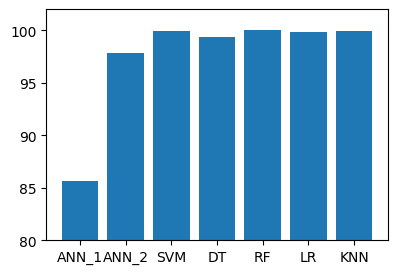

In [135]:
names = ['ANN_1','ANN_2','SVM','DT','RF','LR','KNN']
values = [85.600,97.850,99.924,99.395,99.999,99.799,99.958]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.ylim(80,102)
plt.bar(names,values)

**TESTING ACCURACY**

<BarContainer object of 7 artists>

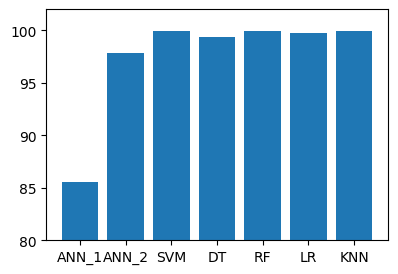

In [136]:
names = ['ANN_1','ANN_2','SVM','DT','RF','LR','KNN']
values = [85.568,97.865,99.897,99.365,99.973,99.782,99.938]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.ylim(80,102)
plt.bar(names,values)